<a href="https://colab.research.google.com/github/deino475/Google-Colab-Notebooks/blob/main/LSTM_for_Predicting_Energy_Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#THIRD PARTY LIBRARIES
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import pytz
from tensorflow import stack
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.metrics import MeanSquaredError

#STANDARD LIBRARIES
from datetime import datetime
import math 
import collections

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#HELPER FUNCTION: FUNCTION THAT DETERMINES WHAT TIME OF DAY IT IS
def return_part_of_day(hour):
	if hour < 5:
		return [0,0,0,1]
	if hour < 12:
		return [1,0,0,0]
	if hour < 17:
		return [0,1,0,0]
	if hour < 21:
		return [0,0,1,0]
	return [0,0,0,1]

#HELPER FUNCTION: FUNCTION THAT DETERMINES DAY OF THE WEEK
def return_day_of_week(day):
	day_ohe = [0,0,0,0,0,0,0]
	day_ohe[day] = 1
	return day_ohe

#HELPER FUNCTION: FUNCTION THAT DETERMINES SEASONALITY
def return_season(month):
	if month in [12, 1, 2]:
		return [0,0,0,1]
	if month in [3, 4, 5]:
		return [1,0,0,0]
	if month in [6, 7, 8]:
		return [0,1,0,0]
	return [0,0,1,0]


In [ ]:
#READ IN ENERGY DATA
energy_df = pd.read_csv('drive/MyDrive/Energy Prediction/data/energy.csv')
energy_df.head()

,datetime_utc_measured,total_demand_kw
0,2016-09-21 14:00:00,1648.8
1,2016-09-21 14:10:00,1641.6
2,2016-09-21 14:15:00,1641.6
3,2016-09-21 14:20:00,1648.8
4,2016-09-21 14:25:00,1677.6


In [ ]:
#CALCULATE MIN AND MAX OF KWH USED
min_kwh = min(energy_df['total_demand_kw'].tolist())
max_kwh = max(energy_df['total_demand_kw'].tolist())

x_features = []
y_features = []

second_covid_case_boston_utc = datetime(2020,3,3)
second_covid_case_boston_local = pytz.utc.localize(second_covid_case_boston_utc, is_dst = True).astimezone(pytz.timezone('US/Eastern'))

#FEATURE ENGINEERING
print('Process data for machine learning model')
for index, row in energy_df.iterrows():
	date_obj = datetime.strptime(row['datetime_utc_measured'], '%Y-%m-%d %H:%M:%S')
	localized_time = pytz.utc.localize(date_obj, is_dst = True).astimezone(pytz.timezone('US/Eastern'))

	part_of_day = return_part_of_day(localized_time.hour)
	day_of_week = return_day_of_week(localized_time.weekday())
	season_of_year = return_season(localized_time.month)

	#FILTER OUT ELECTRICITY DEMAND BEFORE COVID
	'''
	NOTE: DUE TO THE FACT THAT WE ARE SPLITTING TRAINING AND TESTING DATA
	BASED ON TEMPORALITY, THE IMPACT OF COVID WILL NOT BE INCLUDED IN THE
	TRAINING DATA, THUS WOULD NEVER BE ABLE TO ACCURATELY PREDICT THE 
	ELECTRICITY USAGE DURING COVID
	'''
	if localized_time  < second_covid_case_boston_local:
		scaled_kwh = (row['total_demand_kw'] - min_kwh) / (max_kwh - min_kwh)
		x_features.append(part_of_day + day_of_week + season_of_year + [scaled_kwh])
		y_features.append(scaled_kwh)

keras_x_values = []
keras_y_values = []

Process data for machine learning model


In [ ]:
print('Preprocess data for ML model')
for x in range(len(x_features) - 13):
	keras_x_values.append(x_features[x:x+12])
	keras_y_values.append(y_features[x+13])

#SPLIT TRAINING AND TESTING DATA IN HALF
train_x = keras_x_values[0:int(len(keras_x_values) / 2)]
train_y = keras_y_values[0:int(len(keras_y_values) / 2)]
test_x = keras_x_values[int(len(keras_x_values) / 2):]
test_y = keras_y_values[int(len(keras_y_values) / 2):]

train_x = np.asarray(train_x)
test_x = np.asarray(test_x)
train_y = np.asarray(train_y)
test_y = np.asarray(test_y)

Preprocess data for ML model


In [ ]:
#BUILD KERAS MODEL 
print('Building Keras Model')
model = Sequential()
model.add(LSTM(16, input_shape = (12, 16)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

#COMPILE THE MODEL 
model.compile(
	loss = 'mse', 
	optimizer = 'rmsprop',
	metrics = ['mse'] 
)

#TRAIN THE MODEL
history = model.fit(
	train_x, 
	train_y, 
	epochs = 10, 
	batch_size = 128,
	validation_data = (test_x, test_y)
)

Building Keras Model
Epoch 1/10
1416/1416 [==============================] - 15s 9ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 2/10
1416/1416 [==============================] - 12s 9ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 3/10
1416/1416 [==============================] - 12s 9ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 4/10
1416/1416 [==============================] - 12s 9ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 5/10
1416/1416 [==============================] - 12s 9ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/10
1416/1416 [==============================] - 12s 9ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 7/10
1416/1416 [==============================] - 12s 9ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 8/10
1416/1416 [============

In [ ]:
training_predictions = model.predict(train_x)
testing_predictions = model.predict(test_x)

In [ ]:
%matplotlib inline

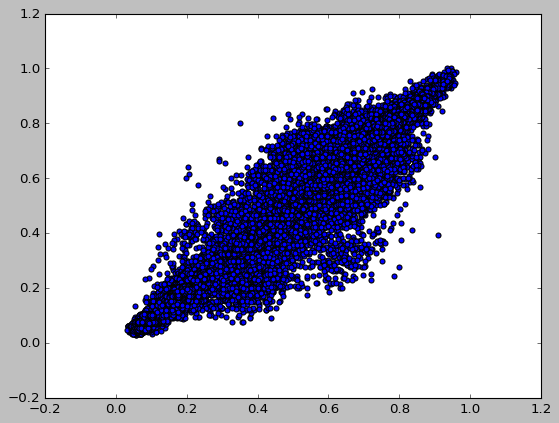

In [ ]:
plt.style.use('classic')
plt.scatter(training_predictions, train_y)

In [ ]:
training_predictions_list = training_predictions.ravel()
np.corrcoef(training_predictions_list, train_y)

array([[1.        , 0.99050602],
       [0.99050602, 1.        ]])

In [ ]:
testing_predictions_list = testing_predictions.ravel()
np.corrcoef(testing_predictions_list, test_y)

array([[1.        , 0.97751881],
       [0.97751881, 1.        ]])

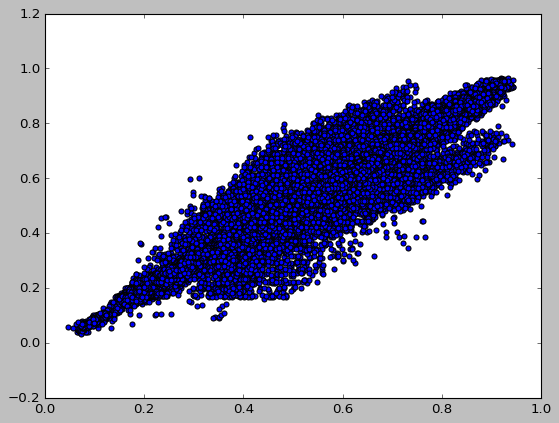

In [ ]:
plt.scatter(testing_predictions, test_y)

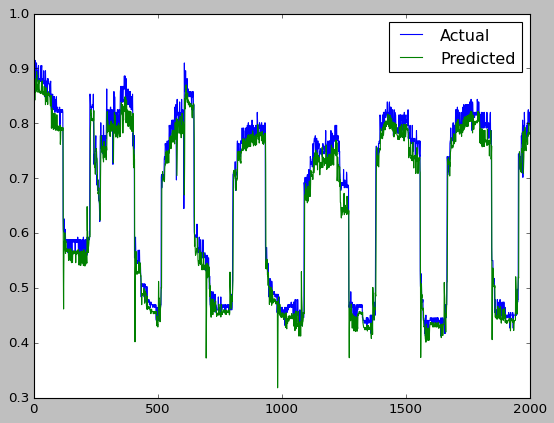

In [ ]:
timeline = range(len(training_predictions_list))
plt.plot(timeline[0:2000], train_y[0:2000], label = 'Actual')
plt.plot(timeline[0:2000], training_predictions_list[0:2000], label = 'Predicted')
plt.legend()

In [ ]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error
y_train_pred = training_predictions_list
y_train_true = train_y

explained_variance_score(y_train_true, y_train_pred)

0.9803010776140144

In [ ]:
r2_score(y_train_true, y_train_pred)

0.9796887536303308

In [ ]:
y_test_pred = testing_predictions_list
y_test_true = test_y
explained_variance_score(y_test_true, y_test_pred)

0.9549306706475763

In [ ]:
r2_score(y_test_true, y_test_pred)

0.9534295370296291

In [ ]:
mean_squared_error(y_test_true, y_test_pred)

0.0016074031033703527